<h1 style="font-size:30px;">DeepLabv3+ with ResNet50_v2 Backbone</h1>

In [1]:
#!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

In [23]:
import os
from datetime import datetime
from glob import glob
from pathlib import Path
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass, field

import image_util as iu
import unet_model


from dotenv import load_dotenv

import random
import numpy as np
import cv2
from datetime import datetime

import tensorflow as tf
import keras_cv
import pandas as pd
import keras
from keras import layers

import matplotlib.pyplot as plt

## Set Seeds for Reproducibility

In [24]:
def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'     
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)

## Download and Extract Dataset

## Configurations

### Data Configuration

In [25]:
segments = {
    0: 'Lumen',  # Lumen
    1: 'Stenose',  # Stenose
    2: 'Multi',  # Lumen and stenose
    }

@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE: tuple = (128, 128)
    BATCH_SIZE: int = 5  # 16
    NUM_CLASSES: int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR: float = 0.2
    MASK: str = segments[0]

### Training Configuration

In [26]:
@dataclass(frozen=True)
class TrainingConfig:
    BACKBONE: str = "resnet50_v2_imagenet",
    WEIGHTS: str = 'imagenet', 
    MODEL: str = "TransUnet"
    EPOCHS: int = 200  # 100 # 35
    LEARNING_RATE: float = 1e-4
    CKPT_DIR: str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]), 
                                        "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".h5")
    LOGS_DIR: str = os.path.join("logs_"+"_".join(MODEL.split("_")[:2]))
    HIST_DIR: str = os.path.join("history_"+"_".join(MODEL.split("_")[:2]),""+"_".join(MODEL.split("_")[:2]))


In [27]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [28]:
load_dotenv()
env_path = Path(".") / ".env"
load_dotenv(dotenv_path=env_path)
PATH = os.getenv("DATA_PATH_128")

print(PATH)

/home/bp/Development/data/DataSet/128


### Load Data and Threshold Masks

In [29]:
train_ds, valid_ds, test_ds = iu.get_data_sets(path=PATH, mask_set=data_config.MASK)

### Unpack Images and Segmentation Masks

The `unpackage_inputs` is a utility function that is used to unpack the inputs from the
dictionary format to a tuple of `(images, segmentation_masks)`. This will be used later
on for visualizing the images and segmentation masks and also the model predictions.

In [9]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

## Ground Truth Visualizations

In [10]:
# Dictionary mapping class IDs to colors.
id2color = {
    0: (0,  0,    0),    # Background
    1: (255, 255, 255),  # lumen
 }

In [11]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):
    
    # single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))
    
    for k in color_map.keys():
        output[num_arr==k] = color_map[k]
        
    return output.astype(np.uint8)

In [12]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

Let us display a few ground truth images along with the corresponding ground truth mask; and have it overlayed on the image input.

In [13]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
    
    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask
        
    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
    
    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)
    
    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")
            
        else:
            axis.imshow(data_list[idx])
            
        axis.axis('off')
        
    plt.show()

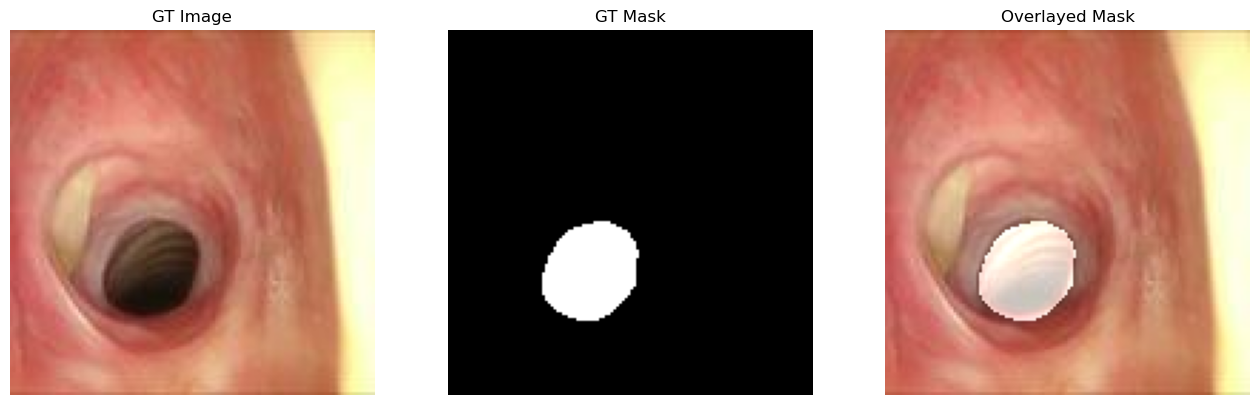

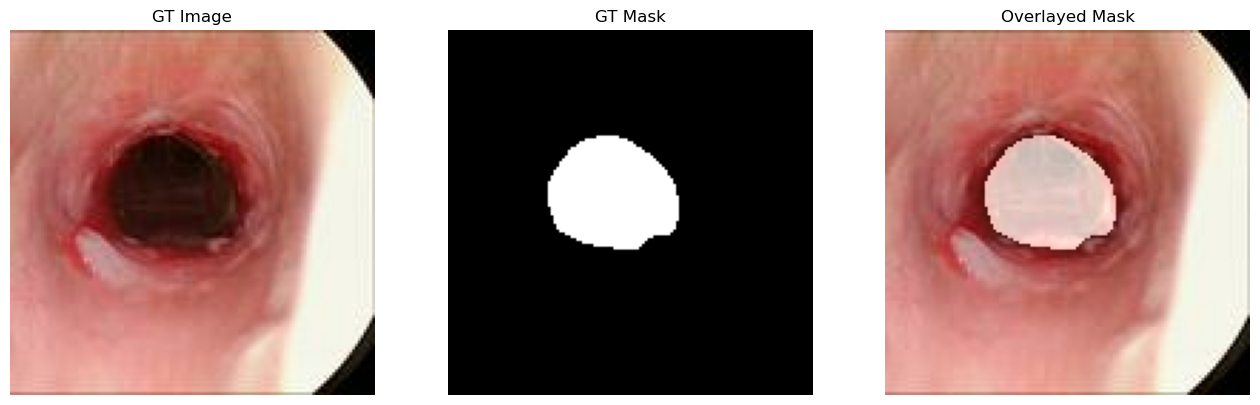

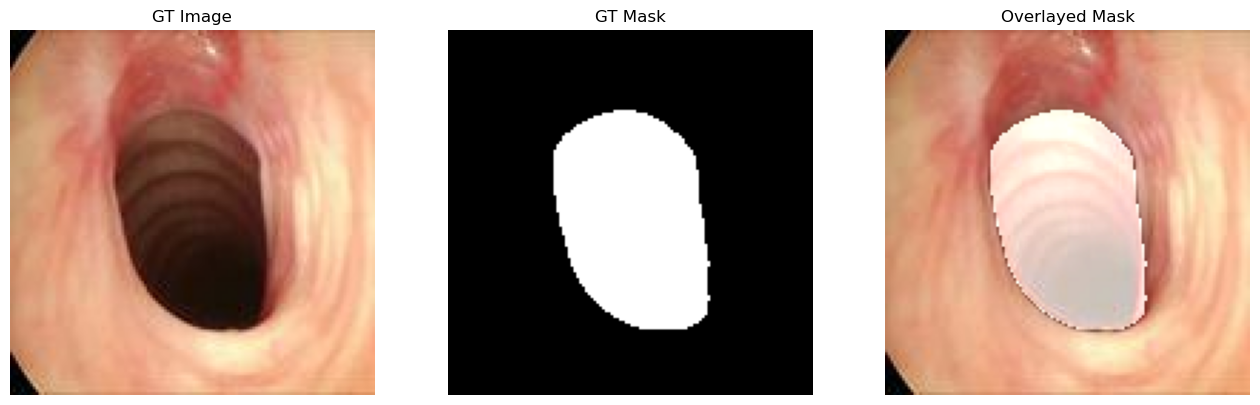

In [14]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):

    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask], 
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=True)

## Data Augmentation

We will use the following transforms as augmentations:
* RandomFlip (default mode is **"horizontal"**, with a probability of `0.5`)
* Random Brightness
* Random Contrast

In [15]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

In [16]:
train_dataset = (
                train_ds.shuffle(data_config.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2024-03-13 21:57:13.405504: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Let's visualized a few images and their segmentation masks from the training data, with
the `keras_cv.visualization.plot_segmentation_mask_gallery` API.

### Visualize Augmented Data

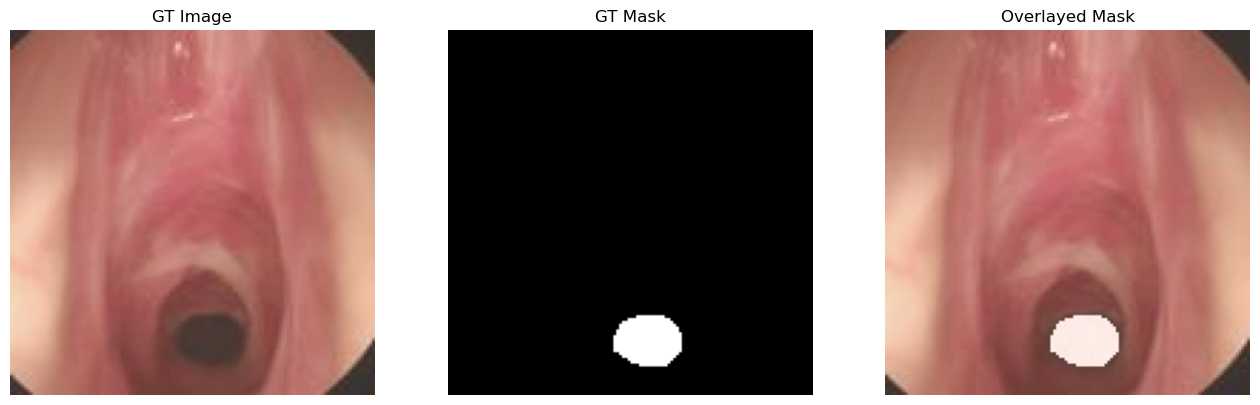

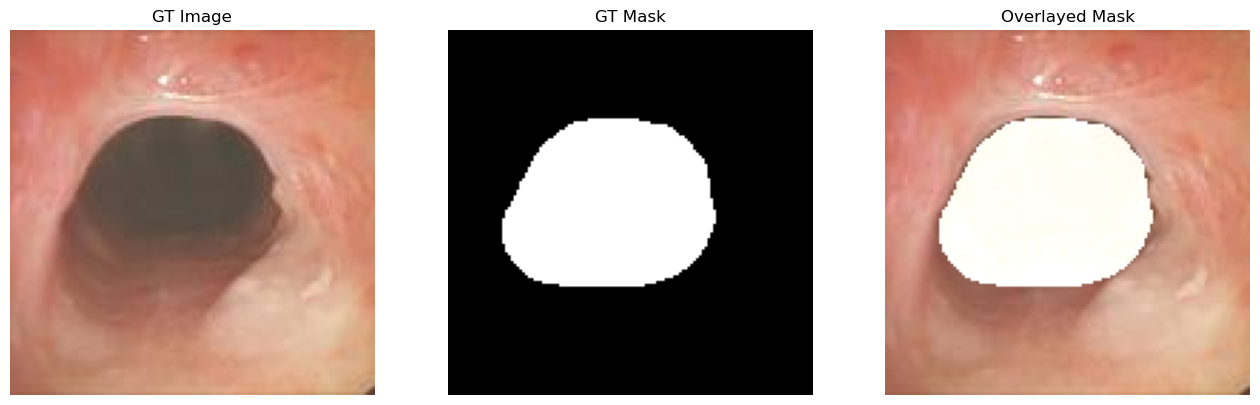

In [17]:
image_batch, aug_mask_batch = next(iter(train_dataset.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for idx, (image, gt_mask) in enumerate(zip(image_batch, aug_mask_batch)):
    if idx > 1:
        break
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask], 
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=False)

## Model Architecture

We will use `resnet50_v2_imagenet` feature extractor on top of the DeepLabv3 Head.

In [30]:
#backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = train_config.MODEL,
#                                                          input_shape=data_config.IMAGE_SIZE+(3,),
#                                                         load_weights = True)


def get_model(img_size=(512,512), num_classes=2):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

#model = keras_cv.models.segmentation.DeepLabV3Plus(
        #num_classes=data_config.NUM_CLASSES, backbone=backbone,
    #)

model = unet_model.get_unet_model(image_size=data_config.IMAGE_SIZE, num_classes=data_config.NUM_CLASSES) 

#print(model.summary())

## Evaluation Metrics

Intersection over Union (IoU) is a metric often used in segmentation problems to assess the model's accuracy. It provides a more intuitive basis for accuracy that is not biased by the (unbalanced) percentage of pixels from any particular class. Given two segmentation masks, `A` and `B`, the IoU is defined as follows:

$$ 
IoU = \frac{|A\cap B\hspace{1mm}|}{|A\cup B\hspace{1mm}|} \hspace{2mm}
$$

When there are multiple classes and inferences, we assess the model's performance by computing the mean IoU.

The function below computes the mean IoU that only considers the classes that are present in the ground truth mask or the predicted segmentation map (sometimes referred to as classwise mean IoU). This computation is a better representation of the metric since it only considers the relevant classes. **This is the metric computation we use for mean IoU.**

In [31]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

### Tensorboard and ModelCheckpoint Callbacks

In [32]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )


    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

## Train the model

Now let's create the model, compile and train by calling `model.fit()` using the configurations defined in the `Trainingconfig` class.

In [33]:
# Build model.

# Get callbacks.
callbacks = get_callbacks(train_config)
# Define Loss.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Compile model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou],
)

In [34]:
# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/200


2024-03-13 22:02:01.817070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:447] Loaded runtime CuDNN library: 8.7.0 but source was compiled with: 8.9.4.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-03-13 22:02:01.842839: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_impl.h:1199 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node model_1/conv2d_9/Conv2D defined at (most recent call last):
  File "/home/bp/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_36236/469649313.py", line 2, in <module>

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/bp/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

DNN library is not found.
	 [[{{node model_1/conv2d_9/Conv2D}}]] [Op:__inference_train_function_19620]

## Plot hostogram of the training results

In [ ]:
print(history.history.keys())

In [ ]:
#print(history.history)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")

# save to csv:
hist_csv_file = 'History_lumen_ResNet50_v2_'+ dt_string +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
print(hist_df)

In [ ]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


# summarize history for mean_iou
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean IoU')
plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()




In [ ]:
plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["mean_iou"])
plt.title("Mean IOU")
plt.ylabel("IoU")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_mean_iou"])
plt.title("Validation Mean IOU")
plt.ylabel("vaL_IoU")
plt.xlabel("epoch")
plt.show()

#### Load Fine-tuned Model Weights

In [ ]:
model.load_weights(train_config.CKPT_DIR)

#### Perform Evaluation

In [ ]:
evaluate = model.evaluate(valid_dataset)

## Prediction with Fine-tuned Model

Now that the model training of DeepLabv3 has been completed, let's test it by making predictions on a few sample images.

In [ ]:
def inference(model, dataset, samples_to_plot):

    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):

        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)
        
        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().squeeze(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break
            

In [ ]:
inference(model, valid_dataset, samples_to_plot=10)